In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from pathlib import Path
import numpy as np
import os
from random import seed
import pickle
import yaml
import imageio

from src.modules.vqvae import VQVae
from src.modules.fsq_vqvae import FSQVAE
from src.modules.res_vqvae import ResVQVae
from train_tokenizer import VQVAEModule
from src.dataset import Dataset
from IPython.display import Image, display
import matplotlib.pyplot as plt

/home/xabieririzar/liveportrait-tokenizer/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
pickle_dir = Path("dataset/pickles")

In [4]:
def load_vqvae(model_path: Path) -> VQVae:
    """
    Load and prepare a VQVAE model from a checkpoint file.
    
    Args:
        model_path (Path): Path to the model checkpoint file
        
    Returns:
        VQVae: Prepared VQVAE model loaded on CUDA and in eval mode
    """
    pretrained = torch.load(model_path)
    model_dir = model_path.parent.parent

    if model_path.suffix == '.ckpt':
        config_path = model_dir / 'wandb' / 'latest-run' / 'files' / 'config.yaml'
    else:
        config_path = model_path.parent / 'wandb' / 'latest-run' / 'files' / 'config.yaml'

    config = yaml.safe_load(open(config_path, "r"))
    feats_enabled = config['feats_enabled']['value']

    print([feat for feat in sorted(feats_enabled) if feats_enabled[feat]['enabled']])
    
    if model_path.suffix == '.ckpt':
        vqvae_module = VQVAEModule(vqvae_config=config["vqvae"]['value'], losses_config=config["losses"])
        vqvae_module.load_state_dict(pretrained['state_dict'])
        vqvae = vqvae_module.vqvae
    else:
        vqvae = VQVae(**config["vqvae"]['value'])
        vqvae.load_state_dict(pretrained)

    vqvae.to("cuda")
    vqvae.eval()
    
    return vqvae, feats_enabled

In [5]:
rest_fsq, rest_feats = load_vqvae(Path("outputs/modified_rest_fsq_D4/checkpoints/checkpoint_epoch=319.ckpt"))

['c_eyes_lst', 'c_lip_lst', 'kp', 't', 'x_s']
FSQ Config:
Levels: [4, 4, 4, 4]
Output Emb Width: 4
Num Quantizers: 1
Using FSQ
Codebook size: 256


In [6]:
rot_scale_fsq, rot_scale_feats = load_vqvae(Path("outputs/modified_rot_scale_D4/checkpoints/checkpoint_epoch=339.ckpt"))

['R', 'scale']
FSQ Config:
Levels: [4, 4, 4, 4]
Output Emb Width: 4
Num Quantizers: 1
Using FSQ
Codebook size: 256


In [37]:
exp_fsq, exp_feats = load_vqvae(Path("outputs/20250526_183238-vae-fsq-exp_rest_with_velocity-D8-L4-lr1e-4-bs32-e2000/checkpoints/checkpoint_epoch=489.ckpt"))

['exp', 'exp_velocity']
FSQ Config:
Levels: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
Output Emb Width: 10
Num Quantizers: 1
Using FSQ
Codebook size: 1048576


RuntimeError: Error(s) in loading state_dict for VQVAEModule:
	size mismatch for vqvae.encoder.branch1.2.0.weight: copying a param with shape torch.Size([512, 512, 2]) from checkpoint, the shape in current model is torch.Size([512, 512, 3]).
	size mismatch for vqvae.encoder.branch1.3.0.weight: copying a param with shape torch.Size([512, 512, 2]) from checkpoint, the shape in current model is torch.Size([512, 512, 3]).

In [8]:
lip_fsq, lip_feats = load_vqvae(Path("outputs/modified_lip_fsq_D4/checkpoints/checkpoint_epoch=249.ckpt"))

['exp', 'exp_velocity']
FSQ Config:
Levels: [4, 4, 4, 4]
Output Emb Width: 4
Num Quantizers: 1
Using FSQ
Codebook size: 256


In [9]:
ds = Dataset("dataset", split="eval", val_split=0.1, seed=2, compute_stats=False)

Loading precomputed statistics from dataset/stats_all.pkl
Loaded feature-wise statistics successfully
Loaded 2045 eval samples


In [10]:

# for seed in range(10):
#     target_ids = ["dataset/pickles/droRkoEh8iE_18.pkl", "dataset/pickles/WQvT1_tQDhg_22.pkl"]

#     counter = 0

#     # find_id = f"dataset/pickles/{test_id}.pkl"

#     for i, item in enumerate(ds):
#         if item['metadata']['pickle_path'] in target_ids:
#             counter += 1
#             print(seed, i)
        
#         if counter == 2:
#             break


### Prepare ds item

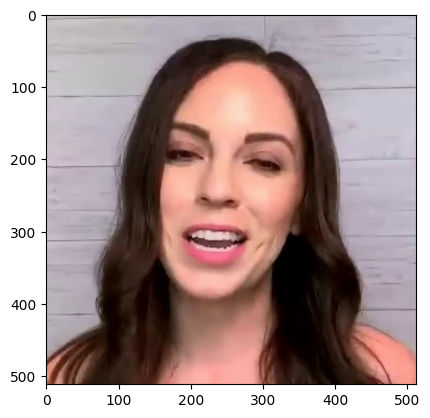

In [11]:
# 1746 guy video
# 3364 girl video

sample = ds[134] 

pickle_path = sample['metadata']['pickle_path']
vid_id = pickle_path.split("/")[-1].split(".")[0]
vid_path = f"dataset/train/{vid_id}.mp4"

# Read the first frame from the video and display it
frame = imageio.get_reader(vid_path).get_data(0)
plt.imshow(frame)
plt.show()


In [12]:
sample['metadata']

{'pickle_path': 'dataset/pickles/WQvT1_tQDhg_22.pkl',
 'n_frames': 147,
 'output_fps': 29.97}

In [13]:
def prepare_features(sample, feats_enabled, only_lips, device="cuda"):
    """
    Prepare features from a sample by processing enabled features and concatenating them.
    
    Args:
        sample (dict): Dictionary containing the sample data
        feats_enabled (dict): Dictionary of enabled features and their metadata
        device (str): Device to move tensors to (default: "cuda")
    
    Returns:
        tuple: (features tensor, dimensions dictionary)
    """
    frames = sample['kp'].shape[0]
    fps = sample['metadata']['output_fps']
    seq_len = min(sample['kp'].shape[0], 300)

    # Initialize an empty tensor list to collect features
    feature_tensors = []
    dims = {}

    for feat, metadata in feats_enabled.items():
        is_enabled = metadata['enabled']
        if is_enabled:
            print(f"Using {feat}")
            if feat in ["exp", "exp_velocity"]:
                if only_lips:
                    feature = sample[feat][:seq_len, :, 15:, :].reshape(1, seq_len, -1)
                else:
                    feature = sample[feat][:seq_len, :, :15, :].reshape(1, seq_len, -1)
            else:
                feature = sample[feat][:seq_len, ...].reshape(1, seq_len, -1)
            
            dims[feat] = feature.shape[-1]
            feature_tensors.append(feature)

    # Concatenate all enabled features
    if feature_tensors:
        features = torch.concat(feature_tensors, dim=2)
    else:
        # Create an empty tensor if no features are enabled
        features = torch.empty((1, seq_len, 0))

    features = features.to(device)
    print("dims: ", dims)
    print("Total dims: ", features.shape[-1])
    
    return features, dims

In [14]:
exp_features, exp_dims = prepare_features(sample, exp_feats, only_lips=False)

Using exp
Using exp_velocity
dims:  {'exp': 45, 'exp_velocity': 45}
Total dims:  90


In [15]:
rest_features, rest_dims = prepare_features(sample, rest_feats, only_lips=False)

Using c_eyes_lst
Using c_lip_lst
Using kp
Using t
Using x_s
dims:  {'c_eyes_lst': 2, 'c_lip_lst': 1, 'kp': 63, 't': 3, 'x_s': 63}
Total dims:  132


In [16]:
r_scale_features, r_scale_dims = prepare_features(sample, rot_scale_feats, only_lips=False)

Using R
Using scale
dims:  {'R': 9, 'scale': 1}
Total dims:  10


In [17]:
feats_lip, lip_dims = prepare_features(sample, lip_feats, only_lips=True)

Using exp
Using exp_velocity
dims:  {'exp': 18, 'exp_velocity': 18}
Total dims:  36


### Load data statistics

In [18]:
# Load stats
stats = pickle.load(open("dataset/stats_all.pkl", "rb"))

In [19]:
# Send stats to GPU
for key in stats['mean']:
    stats['mean'][key] = stats['mean'][key].to("cuda")
    stats['std'][key] = stats['std'][key].to("cuda")
std = stats['std']
mean = stats['mean']

### Reconstruct features

In [20]:
with torch.no_grad():
    reconstr_rest = rest_fsq(rest_features)
    reconstr_r_scale = rot_scale_fsq(r_scale_features)
    reconstr_exp_rest = exp_fsq(exp_features)
    reconstr_lip = lip_fsq(feats_lip)

    # Remove velocity components
    reconstr_exp = torch.cat([reconstr_exp_rest[..., :45], reconstr_lip[..., :18]], dim=-1)
    exp_dims['exp'] = 63


In [21]:
with torch.no_grad():
    rest_indices = rest_fsq.encode(rest_features)
    r_scale_indices = rot_scale_fsq.encode(r_scale_features)
    exp_indices = exp_fsq.encode(exp_features)
    lip_indices = lip_fsq.encode(feats_lip)

print(f"First 10 codes: {rest_indices[:, :10]}")

First 10 codes: tensor([[169, 152,  96, 123, 190, 213, 204, 152,  80, 119]], device='cuda:0',
       dtype=torch.int32)


In [22]:
with torch.no_grad():
    rest_codes = rest_fsq.quantizer.indices_to_codes(rest_indices)
    r_scale_codes = rot_scale_fsq.quantizer.indices_to_codes(r_scale_indices)
    exp_codes = exp_fsq.quantizer.indices_to_codes(exp_indices)
    lip_codes = lip_fsq.quantizer.indices_to_codes(lip_indices)

In [23]:
with torch.no_grad():
    rest_codes = rest_fsq.preprocess(rest_codes)
    r_scale_codes = rot_scale_fsq.preprocess(r_scale_codes)
    exp_codes = exp_fsq.preprocess(exp_codes)
    lip_codes = lip_fsq.preprocess(lip_codes)

In [50]:
with torch.no_grad():
    reconstr_rest = rest_fsq.decoder(rest_codes)
    reconstr_r_scale = rot_scale_fsq.decoder(r_scale_codes)
    reconstr_exp_rest = exp_fsq.decoder(exp_codes)
    reconstr_lip = lip_fsq.decoder(lip_codes)

    reconstr_rest = rest_fsq.postprocess(reconstr_rest)
    reconstr_r_scale = rot_scale_fsq.postprocess(reconstr_r_scale)
    reconstr_exp_rest = exp_fsq.postprocess(reconstr_exp_rest)
    reconstr_lip = lip_fsq.postprocess(reconstr_lip)

    reconstr_exp = torch.cat([reconstr_exp_rest[..., :45], reconstr_lip[..., :18]], dim=-1)
    exp_dims['exp'] = 63


In [23]:
(rest_features - reconstr_rest).mean

<function Tensor.mean>

### Test encoding features

In [21]:
# with torch.no_grad():
#     encodings = rest_fsq.encode(rest_features)
#     result = rest_fsq.decode(encodings)

In [22]:
def process_reconstruction(dims, reconstr, exp_lips, std, mean):
    """
    Process reconstruction tensor by filtering out velocity dimensions and applying normalization.
    
    Args:
        dims (dict): Dictionary containing feature dimensions
        reconstr (torch.Tensor): Reconstruction tensor
        std (dict): Dictionary of standard deviations for normalization
        mean (dict): Dictionary of means for normalization
        
    Returns:
        torch.Tensor: Processed reconstruction tensor
    """
    # Filter out velocity dimensions and add lip dimensions to exp
    filtered_dims = {k: v for k, v in dims.items() if k not in ['kp_velocity', 'kp_acceleration', 'exp_velocity']}

    total_dims = sum(filtered_dims.values())

    # Initialize output tensor
    new_reconstr = torch.zeros((*reconstr.shape[:-1], total_dims))

    cur_ind = 0
    reconstr_ind = 0
    for feat, indices in dims.items():
        if 'velocity' in feat:
            # Skip velocity in new_reconstr but still increment reconstr_ind
            reconstr_ind += indices
            continue
            
        print(f"{feat} {cur_ind} : {cur_ind + indices}")
        new_reconstr[..., cur_ind:cur_ind + indices] = reconstr[..., reconstr_ind:reconstr_ind + indices] * std[feat] + mean[feat]
            
        cur_ind += indices
        reconstr_ind += indices

    return new_reconstr

In [23]:
rest_new_reconstr = process_reconstruction(rest_dims, reconstr_rest, False, std, mean)

c_eyes_lst 0 : 2
c_lip_lst 2 : 3
kp 3 : 66
t 66 : 69
x_s 69 : 132


In [24]:
r_scale_new_reconstr = process_reconstruction(r_scale_dims, reconstr_r_scale, False, std, mean)

R 0 : 9
scale 9 : 10


In [25]:
exp_new_reconstr = process_reconstruction(exp_dims, reconstr_exp, False, std, mean)

exp 0 : 63


In [26]:
new_reconstr = torch.zeros((*rest_new_reconstr.shape[:-1], 205))
new_reconstr[..., :9] = r_scale_new_reconstr[..., :9]
new_reconstr[..., 9:12] = rest_new_reconstr[..., :3]
new_reconstr[..., 12:75] = exp_new_reconstr
new_reconstr[..., 75:138] = rest_new_reconstr[..., 3:66]
new_reconstr[..., 138:139] = rest_new_reconstr[..., 75:76]
new_reconstr[..., 138:139] = r_scale_new_reconstr[..., 9:10]
new_reconstr[..., 139:142] = rest_new_reconstr[..., 66:69]
new_reconstr[..., 142:205] = rest_new_reconstr[..., 69:132]

In [27]:
new_dims = {
    'R': 9,
    'c_eyes_lst': 2,
    'c_lip_lst': 1,
    'exp': 63,
    'kp': 63,
    'scale': 1,
    't': 3,
    'x_s': 63
}

In [28]:
# zeros = torch.zeros(1, new_reconstr.shape[1], new_reconstr.shape[-1] + 18)
# # full_exp = sample['exp'][:95].reshape(1, 95, -1).to('cuda')

# cur_ind = 0
# reconstr_ind = 0

# for feat, indices in dims.items():
#     print(f"{feat}: {cur_ind}: {cur_ind + indices}")
#     if feat == 'exp':
#         zeros[..., cur_ind: cur_ind + indices] = new_reconstr[..., reconstr_ind: reconstr_ind + indices] 
#         # zeros[..., cur_ind: cur_ind + indices] = full_exp[..., reconstr_ind: reconstr_ind + indices] 
#         zeros[..., cur_ind + indices: cur_ind + indices + 18] = reconst_lip * std[feat][:, 45:] + mean[feat][:, 45:]
#         cur_ind += indices + 18
        
#         reconstr_ind += indices
#     else:
#         zeros[..., cur_ind: cur_ind + indices] = new_reconstr[..., reconstr_ind: reconstr_ind + indices]
#         cur_ind += indices
#         reconstr_ind += indices

In [29]:
# full_feats = sample['exp'][:300].reshape(1, 300, -1).to('cuda')
# zeros = torch.zeros_like(full_feats, device='cuda')
# zeros[..., :45] = new_reconstr
# zeros[..., 45:] = full_feats[..., 45:] * std['exp'][:, 45:] + mean['exp'][:, 45:]

# new_reconstr = zeros

### Generate reconstructed pickle

In [30]:
new_rest_feats = {}

for key, value in rest_feats.items():
    new_rest_feats[key] = value
    new_rest_feats[key]['enabled'] = True

In [31]:
# Prepare output
def repackage_output(original, reconstr, dataset, dims):
    # Get normalized tensors from reconstruction
    reconstr = reconstr.to('cpu').squeeze(0)
    frames = reconstr.shape[0]
    print("Frames: ", frames)

    start = 0
    end = 0

    main_feats = {
        "kp": None,
        "exp": None,
        "x_s": None,
        "t": None,
        "R": None,
        "scale": None,
        "c_eyes_lst": None,
        "c_lip_lst": None
    }

    for feat, metadata in new_rest_feats.items():
        is_enabled = metadata['enabled']
        feat_shape = metadata['shape']

        if is_enabled and feat in main_feats:
            end += dims[feat]
            print(f"{feat}: {start}:{end}")
            if feat == "exp":
                rec_feat = reconstr[:, start:end].reshape(-1, *feat_shape)
            else:
                rec_feat = reconstr[:, start:end].reshape(-1, *feat_shape)
            main_feats[feat] = rec_feat
            start += dims[feat]
    
    # Denormalize original features too (since they come from __getitem__)
    orig_kps = dataset.denormalize_features(original['kp'], "kp")
    orig_exp = dataset.denormalize_features(original['exp'], "exp")
    orig_x_s = dataset.denormalize_features(original['x_s'], "x_s")
    orig_t = dataset.denormalize_features(original['t'], "t")
    orig_R = dataset.denormalize_features(original['R'], "R")
    orig_scale = dataset.denormalize_features(original['scale'], "scale").squeeze(-1)
    orig_c_eyes_lst = dataset.denormalize_features(original['c_eyes_lst'], "c_eyes_lst")
    orig_c_lip_lst = dataset.denormalize_features(original['c_lip_lst'], "c_lip_lst")

    # Print which features are enabled and will be used
    print("Enabled features:")
    for feat, metadata in new_rest_feats.items():
        if metadata['enabled'] and 'velocity' not in feat and 'acceleration' not in feat:
            print(f"- {feat}")

    n_frames = min(original['metadata']['n_frames'], frames)

    output = {
        "n_frames": n_frames,
        "output_fps": original['metadata']['output_fps'],
        "motion": [
            {
                "kp": main_feats['kp'][i].cpu().numpy() if new_rest_feats['kp']['enabled'] else orig_kps[i].cpu().numpy(),
                "exp": main_feats['exp'][i].cpu().numpy() if new_rest_feats['exp']['enabled'] else orig_exp[i].cpu().numpy(),
                "x_s": main_feats['x_s'][i].cpu().numpy() if new_rest_feats['x_s']['enabled'] else orig_x_s[i].cpu().numpy(),
                "t": main_feats['t'][i].cpu().numpy() if new_rest_feats['t']['enabled'] else orig_t[i].cpu().numpy(),
                "R": main_feats['R'][i].cpu().numpy() if new_rest_feats['R']['enabled'] else orig_R[i].cpu().numpy(),
                "scale": main_feats['scale'][i].cpu().numpy() if new_rest_feats['scale']['enabled'] else orig_scale[i].cpu().numpy(),
            } for i in range(frames)
        ],
        "c_eyes_lst": [main_feats['c_eyes_lst'][i].cpu().numpy() if new_rest_feats['c_eyes_lst']['enabled'] else orig_c_eyes_lst[i].cpu().numpy() for i in range(frames)],
        "c_lip_lst": [main_feats['c_lip_lst'][i].cpu().numpy() if new_rest_feats['c_lip_lst']['enabled'] else orig_c_lip_lst[i].cpu().numpy() for i in range(frames)],
    }
    return output

In [32]:
output = repackage_output(sample, new_reconstr, ds, dims=new_dims)

Frames:  147
R: 0:9
c_eyes_lst: 9:11
c_lip_lst: 11:12
exp: 12:75
kp: 75:138
scale: 138:139
t: 139:142
x_s: 142:205
Enabled features:
- R
- c_eyes_lst
- c_lip_lst
- exp
- kp
- scale
- t
- x_s


In [33]:
# # Replace reconstructed features with original ones for a specific range
# feat = 'exp'

# feat_range = (0, 1)

# for i in range(output['n_frames']):
#     output['motion'][i][feat][:, feat_range[0]:feat_range[1]] = sample[feat][i][:, feat_range[0]:feat_range[1]]

# denormalized_sample = ds.denormalize_features(sample[feat], feat)

# for i in range(output['n_frames']):
#     output['motion'][i][feat] = denormalized_sample[i]

In [34]:
video_id = Path(pickle_path).stem
new_path = pickle_dir / f"{video_id}_reconstructed.pkl"
print(new_path)
with open(new_path, "wb") as f:
    pickle.dump(output, f)

dataset/pickles/WQvT1_tQDhg_22_reconstructed.pkl


In [35]:
import imageio

vid = imageio.get_reader(f"dataset/train/{video_id}.mp4")
frame = vid.get_data(0)

# save frame
imageio.imwrite("assets/examples/source/reconstructed.png", frame)

In [36]:
!python inference.py -d {new_path} -s assets/examples/source/reconstructed.png

[22:08:08] Load appearance_feature_extractor from    ]8;id=586238;file:///home/xabieririzar/liveportrait-tokenizer/src/live_portrait_wrapper.py\live_portrait_wrapper.py]8;;\:]8;id=685780;file:///home/xabieririzar/liveportrait-tokenizer/src/live_portrait_wrapper.py#46\46]8;;\
           /home/xabieririzar/liveportrait-tokenizer                            
           /pretrained_weights/liveportrait/base_mod                            
           els/appearance_feature_extractor.pth                                 
           done.                                                                
           Load motion_extractor from                ]8;id=560936;file:///home/xabieririzar/liveportrait-tokenizer/src/live_portrait_wrapper.py\live_portrait_wrapper.py]8;;\:]8;id=442522;file:///home/xabieririzar/liveportrait-tokenizer/src/live_portrait_wrapper.py#49\49]8;;\
           /home/xabieririzar/liveportrait-tokenizer                            
           /pretrained_weig